## **Mountain Car Problem: Introduction**

The mountain car problem is a classical control problem that illustrates the dynamics of a car moving on a profile. This problem is influenced by gravity, the profile's inclination, and an applied acceleration input, as depicted in the figure below. Our primary objective is to design a control policy using various methods (e.g. LQR, MPC, and RL) to drive the car from an initial state $x_0$ to a predefined terminal state $x_T$, all while being subject to constraints.

![Figure 1: Illustration of a mountain car problem](../figure/MountainCarIllustration.png)

## **Variations of the Mountain Car Problem**

The mountain car problem can be set up in different ways to study various aspects of this control problem and can be divided into the following categories:


### 1. **Type of Task**

- **Terminal State Reaching**: The classic setting where the car must reach a target state (e.g., the hilltop) as quickly or efficiently as possible.  

- **Stabilization**: The goal is to stabilize the car at a designated equilibrium point **(the focus of this Jupyter Notebook series)**.  

- **Trajectory Tracking**: The car is required to follow a predefined trajectory over time.  

- **Time-Optimal Control**: The focus is on minimizing the number of time steps to reach the target.  


### 2. **Type of Dynamics**

- **Continuous-time Dynamics**: describe systems whose states evolve continuously over time, typically modeled by differential equations such as $\dot{x}(t)=f(x(t),u(t))$. The dynamic equations derived from first principles or Newton's laws are continuous-time dynamic equations.  

- **Discrete-time Dynamics**: describe systems whose states evolve at distinct time steps, typically modeled by difference equations such as $x_{k+1}=f(x_k,u_k)$. Due to the inherently discrete nature of computer systems, the dynamic equations followed by any controller that needs to be practically applied are discrete-time equations.  

- **Linear Dynamics**: the future behavior of the system depends linearly on its current state and input, typically expressed as $\dot{x}=Ax+Bu$. Always used for simplified analysis or as a local approximation near equilibrium points. For example the car moving along a flat ground or a slope with constant inclination angle.  

- **Nonlinear Dynamics**: the general case that captures the nonlinear evolution of the system dynamcis, typically expressed as $\dot{x}=f(x,u)$. Especially introducing the gravitational effects and nonlinear terrain profiles, making the problem significantly harder to solve but also more realistic.  


### 3. **Type of State and Input**

- **Continuous State / Input**: the state or input variables can take any value within a continuous range.

- **Discrete State / Input**: the state or input variables can only take values from a countable set, often finite or indexed by integers. A general example of discrete state space together with discrete input space  is the Traveling Salesman Problem (TSP).

- **Unconstrained State / Input**:  the state or input variables are free to take any value, which means $\boldsymbol{x} \in \mathcal{R}^n$ and $\boldsymbol{u} \in \mathcal{R}^m$

- **Constrained State / Input**:  the state or input variables are restricted to lie within specified bounds or satisfy certain conditions, reflecting physical or actuator limits.


These variations enable researchers and practitioners to explore a broad spectrum of control strategies, from classical methods (e.g., PID, LQR) to modern techniques (e.g., MPC, reinforcement learning), under diverse dynamics and objectives.



----


### **Chapter 1: Problem Definition and Dynamic Programming**


In the first chapter, we will introduce the mountain car problem and demonstrate how to implement a Dynamic Progamming (DP)-based controller. We begin with implementing the mountain car environment (e.g., defining the slope and constraints), followed by defining the system dynamics and implementing the controller based on DP. The contents are summarized in the table below.  

<table border="1" style="border-collapse: collapse; text-align: center;">
  <!-- Title Row -->
  <tr>
    <th colspan="2" style="text-align:center">Content of Chapter 1 Exercise</th>
  </tr>

  <!-- Row group 1 -->
  <tr>
    <td rowspan="2">Mountain Car Environment</td>
    <td>define mountian profile</td>
  </tr>
  <tr>
    <td>define mapping from mountian profile to inclination angle</td>
  </tr>

  <!-- Row group 2 -->
  <tr>
    <td rowspan="3">System Dynamics</td>
    <td>define symbolic expression of system dynamics</td>
  </tr>
  <tr>
    <td>linearization of system dynamics</td>
  </tr>
  <tr>
    <td>discretization of system dynamics</td>
  </tr>

  <!-- Row group 3 -->
  <tr>
    <td rowspan="2">Dynamic Programming (continuous input)</td>
    <td>implement the DPA for continuous input case</td>
  </tr>
  <tr>
    <td>simulation and visualization</td>
  </tr>

  <!-- Row group 4 -->
  <tr>
    <td rowspan="2">Dynamic Programming (discrete input)</td>
    <td>implement the DPA for discrete input case</td>
  </tr>
  <tr>
    <td>simulation and visualization</td>
  </tr>
</table>


First, we need to set up our Python environment and import relevant packages.

In [1]:
# Import all related classes from the predefined repo
import sys
import os
sys.path.append(os.path.abspath(".."))
from rest.utils import *

import numpy as np
import casadi as ca

----

#### **Part (a): Mountain Car Environment**


In this part, we set up the environment for the mountain car problem. The environment consists of defining the terrain profile, mapping the terrain to inclination angles, and specifying task parameters for the controller. The steps include creating a mathematical representation of the terrain, deriving the relationship between the slope and inclination angle, and finally specifying parameters such as the initial state, terminal state, and constraints to uniquely define a control task.


**Step 1: The Mountain Profile $h(p)$**

The mountain profile describes the height $h$ with reference to horizontal position $p$. As mentioned above, there are different choices for the mountain profile in the mountain car problem. Here we specifically designed 4 cases (as shown in the figure below), where we have 2 linear cases and 2 nonlinear cases:

 - Case 1: zero slope (linear system);
 
 - Case 2: constant slope (linear system);
 
 - Case 3: varying slope for small disturbance (nonlinear system);
 
 - Case 4: varying slope and underactuated system (nonlinear system).

*Note that: The underactuated case refers to a scenario where the input is limited and may be insufficient to generate enough force to climb uphill directly.*

![Figure 2: Different mountain profile choices](../figure/MountainProfileCases.png)

The analytical expressions of the profiles are:

 - Case 1: $\quad h(p) = c,$

 - Case 2: $\quad h(p) = \frac{\pi}{18} \cdot p,$

 - Case 3: $\quad h(p) = 0.1 \cdot cos(18 p)$

 - Case 4: $\quad h(p) = \begin{cases} sin(3 p), & p \in [- \frac{\pi}{2}, \frac{\pi}{6}] \\ 1, & p \in (-\infty, -\frac{\pi}{2}) \cup (\frac{\pi}{6}, \infty) \end{cases}$


In [2]:
# Define the profile of mountain h(p)
#  - argument: 1) p: CasAdi symbolic expression `p`
#              2) case: integer value to choose the mountain's profile
#  - return: value of `h`

def h(p, case):
    
    # zero slope
    if case == 1:
        h = 0
   
    # constant slope
    elif case == 2: 
        h = (ca.pi * p) / 18
    
    # varying slope
    elif case == 3: 

        h = 0.1 * ca.cos(18 * p)

    # varying slope for underactated case
    elif case == 4: 
        h_center = ca.sin(3 * p)
        h_flat = 1

        condition_left = p <= -ca.pi/2
        condition_right = p >= ca.pi/6

        h = ca.if_else(condition_left, h_flat, ca.if_else(condition_right, h_flat, h_center))

    return h


**Step 2: Mapping From Profile $h(p)$ to Inclination Angle $\theta(p)$**

- Transformation function from $h$ to $\theta$:

   \begin{align*}
     \theta = \arctan\left(\frac{dh}{dp}\right)
   \end{align*}

- Hint: 

  1. Using the CasAdi symbolic expression as the input, we can directly solve the gradient $\frac{dh}{dp}$ with method `ca.jacobian(h, p)`; 

  2. The angle $\theta$ is defined in radian;  

- Notice: If the function $h(p)$ is defined numerically rather than symbolically, we can use **numerical differentiation** to approximate $\frac{dh}{dp}$.

In [3]:
# Calculate inclination angle theta(p) based on terrain profile h(p)
#  - argument: CasAdi symbolic expression `h_func`
#  - return: CasAdi symbolic expression `theta(p)`

def symbolic_theta(h_func):

    p = ca.SX.sym("p")

    h = h_func(p) 
    dh_dp = ca.jacobian(h, p)
    theta = ca.atan(dh_dp)
    
    return ca.Function("theta", [p], [theta])


**Step 3: Environment Parameters and Control Task**

- Task: start from given initial position $p_0$, to reach a given target position $p_T$ (Stabilization)

- You may use the pre-defined method `test_env()` to check the slope $h(p)$ and and the inclination angle $\theta(p)$.



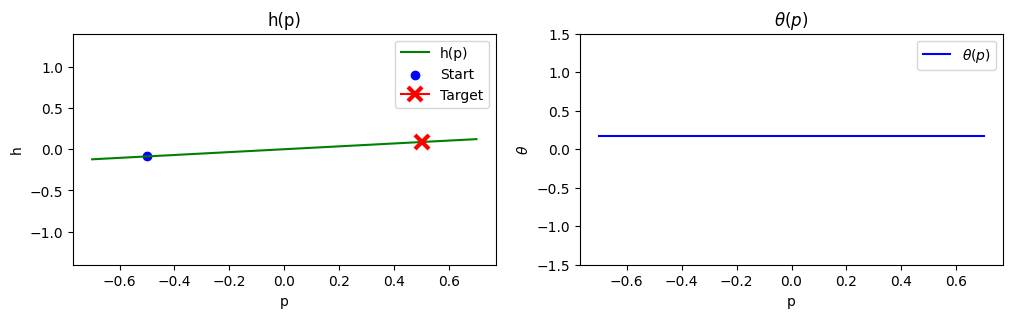

In [4]:
case = 2 # 1 / 2

# Define the initial / target state
initial_position = -0.5
initial_velocity = 0.0
target_position = 0.5
target_velocity = 0.0

# Define the state / input constraints
state_lbs = None
state_ubs = None
input_lbs = None
input_ubs = None

# Instantiate class 'Env'
#  - argument: 1) `case`: n in [1, 2], type: int
#              2) `initial state`: x_0 = [p_0, v_0] ^ T, type: np.array
#              3) `terminal state`: x_T = [p_T, v_T] ^ T, type: np.array
#              4) `h`: mountain profile w.r.t. cases (defined in step 1), type: function
#              5) `symbolic_theta`: CasADi symbolic expression of inclination angle (defined in step 2), type: ca.Function
#              6) constraints on states and inputs:
#                  - `state_lbs`: lower limit of state, type: np.array or None (if no related limit)
#                  - `state_ubs`: upper limit of state, type: np.array or None (if no related limit)
#                  - `input_lbs`: lower limit of input, type: np.array or None (if no related limit)
#                  - `input_ubs`: upper limit of input, type: float or None (if no related limit)

env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]), h, symbolic_theta, 
          state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)

# Results visualisation
env.test_env() #  shape of slope (left side) and theta curve (right side) 

----

#### **Part (b): System Dynamics**


In the previous section, we defined the mountain car environment, including the terrain profile and the mapping from the profile to the inclination angle. In this section, we define a class that describes the system dynamics of the mountain car on this mountain profile. This includes specifying the state and input vectors, constructing the dynamics equations using symbolic computation in CasADi, and linearization and discretization.

Consider the following set of parameter that describe the motion of the mountain car:

   - the horizontal position of the car $p$;
   - the driving force $F_u=mu$, where $u$ is the acceleration supplied by engine, and is parallel to the mountain surface.

The following figure illustrates the free-body diagram of the mountain car, where its motion is influenced by the driving force, gravitational force, and the normal force.

![Figure 3: FBD of mountaincar problem](../figure/MountaincarFBD.png)

By applying Newton's second law along the horizontal direction, the equation of motion can be expressed as:

$$m\ddot{p} = (mu-mg\sin(\theta))\cos(\theta),$$


where $m$ represents the mass of the car, $g$ is the acceleration due to gravity, and $\theta$ denotes the inclination angle of the slope. This equation can be reformulated into a system of first-order differential equations as follows:
$$
  \left\{
  \begin{aligned}
  \dot{p} &= v, \\
  \dot{v} &= -g\sin(\theta)\cos(\theta)+u\cos(\theta),
  \end{aligned}
  \right.
$$

To facilitate analysis and control design, the system dynamics can be expressed in a state-space representation:

   - state vector $\boldsymbol{x} = [p, v]^T$
   - input vector $u$
   - system dynamics:
   \begin{align*}
     \begin{bmatrix} \dot{p} \\ \dot{v} \end{bmatrix} = \begin{bmatrix} v \\ - g \sin(\theta) \cos(\theta) \end{bmatrix} + \begin{bmatrix} 0 \\ \cos(\theta)  \end{bmatrix} u
   \end{align*}

*Note that: Dynamics equations derived from first principles, such as Newton's laws, are inherently continuous in time and generally nonlinear. To enhance computational efficiency, it is common practice to linearize and discretize these equations as step 2 and 3.*


**Step 1: Setup the Mountain Car Dynamics**

- Hints about defining CasADi symbolic expression: 

  1. The variables used for symbolic computation should be declared in datatype `ca.SX` or `ca.MX`;

  2. To combine several variables into a vector, use `ca.vertcat(a, b, ...)`;

  3. To define a CasADi function, use `ca.Function("function_name", [input1, input2, ...], [output])`;
  
  4. To call a CasADi function, use `function_name(input1, input2, ...))`;

- Supplementary materials:
  
  1. Introduction to symbolic modeling in CasADi: https://web.casadi.org/docs/#document-symbolic
  
  2. CasADi's Python API: https://web.casadi.org/python-api/
  

In [5]:
# Define dynamics of 1d mountain car
#  - arguments: `theta_function`: CasADi symbolic function of inclination angle `theta_function`, type: ca.Function
#  - return: `dynamics_function`: CasADi symbolic function of dynamics, type: ca.Function

def setup_dynamics(theta_function):

    p = ca.SX.sym("p")
    v = ca.SX.sym("v")
    u = ca.SX.sym("u")
    
    Gravity = 9.81

    theta = theta_function(p)

    # Expression of dynamics
    dpdt = v
    dvdt = u * ca.cos(theta) - Gravity * ca.sin(theta) * ca.cos(theta)
    
    state = ca.vertcat(p, v)
    input = ca.vertcat(u)
    rhs = ca.vertcat(dpdt, dvdt)

    return ca.Function("dynamics_function", [state, input], [rhs])



**Step 2: Linearizing the System Dynamics**

The derived equations of motion above are typically written in the form of $\dot{\boldsymbol{x}} = \boldsymbol{f} (\boldsymbol{x}, \boldsymbol{u})$, where $\boldsymbol{x}$ is the state, $\boldsymbol{u}$ is the input, and $\boldsymbol{f}: n \times m \to n$ denote the mapping from state and input to the derivatives of the state. Generally speaking, the function $\boldsymbol{f}$ is nonlinear, which means the evolution of the system dynamics cannot be captured by simple linear algebraic operations such as matrix multiplication. This significantly increases the complexity of solving the problem. To simplify the problem, especially in the context of local analysis or model-based control (e.g., LQR, MPC), it is a common practice to **linearize** the nonlinear dynamics around a given **operating point**.


Assume we are interested in the behavior of the system near some nominal point $(\boldsymbol{x}_0, \boldsymbol{u}_0)$. We perform a **first-order Taylor expansion** of $\boldsymbol{f}(\boldsymbol{x}, \boldsymbol{u})$ around this point:  

$$
\boldsymbol{f}(\boldsymbol{x}, \boldsymbol{u}) \approx \boldsymbol{f}(\boldsymbol{x}_0, \boldsymbol{u}_0) + 
\left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{x}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)} 
(\boldsymbol{x} - \boldsymbol{x}_0) +
\left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{u}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)} 
(\boldsymbol{u} - \boldsymbol{u}_0).
$$

We define the **perturbation variables** as:  

$$
\boldsymbol{\overline{x}} = \boldsymbol{x} - \boldsymbol{x}_0, \quad
\boldsymbol{\overline{u}} = \boldsymbol{u} - \boldsymbol{u}_0.
$$

Substitute them into the expansion:  

$$
\dot{\boldsymbol{x}} - \boldsymbol{f}(\boldsymbol{x}_0, \boldsymbol{u}_0) \approx 
\left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{x}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)} \boldsymbol{\overline{x}} + \left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{u}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)} \boldsymbol{\overline{u}}.
$$

Since $\dot{\boldsymbol{x}}_0 = \boldsymbol{f}(\boldsymbol{x}_0, \boldsymbol{u}_0)$ and $\dot{\boldsymbol{\overline{x}}} = \dot{\boldsymbol{x}} - \dot{\boldsymbol{x}}_0$, the **linearized system dynamics** around the nominal point become:  

$$
\dot{\boldsymbol{\overline{x}}} = \boldsymbol{A}_c \boldsymbol{\overline{x}} + \boldsymbol{B}_c \boldsymbol{\overline{u}},
$$

with state matrix $\boldsymbol{A}_c$ and input matrix $\boldsymbol{B}_c$ defined as:  

$$
\boldsymbol{A}_c = \left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{x}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)}, \quad
\boldsymbol{B}_c = \left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{u}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)}.
$$

This linearized model accurately approximates the original nonlinear system **locally**, i.e., within a small neighborhood around the point $(\boldsymbol{x}_0, \boldsymbol{u}_0)$, and forms the basis for many powerful linear control design techniques.

*Note that: To simplify notation and avoid ambiguity, we will omit the overbars on variables $\boldsymbol{\overline{x}}$ and $\boldsymbol{\overline{u}}$ in the following discussions of continuous-time system dynamics. This simplification is intended to streamline expressions without loss of clarity.*



In [6]:
def linearization_external(
    self,
    current_state: np.ndarray, 
    current_input: np.ndarray, 
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute symbolic Jacobians A(x,u) & B(x,u) and state / input matrix A & B of the system dynamics.
    """

    f = self.dynamics_function(self.states, self.inputs)
    A_c_sym = ca.jacobian(f, self.states)
    B_c_sym = ca.jacobian(f, self.inputs)

    self.A_c_func = ca.Function("A_func", [self.states, self.inputs], [A_c_sym])
    self.B_c_func = ca.Function("B_func", [self.states, self.inputs], [B_c_sym])

    A_c = np.array(self.A_c_func(current_state, current_input))
    B_c = np.array(self.B_c_func(current_state, current_input))

    return A_c, B_c

**Step 3: Discretization of the system dynamics**

After linearizing the continuous-time nonlinear system, we obtain a system in the form:

$$
\dot{\boldsymbol{x}}(t) = \boldsymbol{A_c} \boldsymbol{x}(t) + \boldsymbol{B_c} \boldsymbol{u}(t).
$$

Due to the inherently discrete nature of modern computing and control systems, our goal is to convert this into a discrete-time system of the form:

$$
\boldsymbol{x}_{k+1} = \boldsymbol{A_d} \boldsymbol{x}_k + \boldsymbol{B_d} \boldsymbol{u}_k.
$$

We assume that during each sampling interval $[k\Delta t, (k+1)\Delta t)$, the input $\boldsymbol{u}(t)$ remains **constant**. This as also known as the **Zero-order hold (ZOH)**, which is a mathematical model used to describe signal reconstruction in traditional digital-to-analog converters (DACs). The exact discretization under ZOH is:

$$
\boldsymbol{A_d} = e^{\boldsymbol{A_c} \Delta t}, \quad
\boldsymbol{B_d} = \left( \int_0^{\Delta t} e^{\boldsymbol{A_c} \tau} d\tau \right) \boldsymbol{B_c}.
$$

Instead of computing $\boldsymbol{B_d}$ using numerical integration, we can use the **augmented matrix exponential** trick:

$$
\exp \left(
\begin{bmatrix}
\boldsymbol{A_c} & \boldsymbol{B_c} \\
0 & 0
\end{bmatrix} \Delta t 
\right)
=
\begin{bmatrix}
\boldsymbol{A_d} & \boldsymbol{B_d} \\
0 & I
\end{bmatrix}.
$$

*Note that: this process can also be performed automatically using `scipy.signal.cont2discrete((A, B, C, D), dt)`*

In [7]:
def discretization_external(
    self,
    A_c: np.ndarray,
    B_c: np.ndarray,
    dt: float
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Discretize continuous-time linear system x_dot = A_c x + B_c u
    using matrix exponential method (Zero-Order Hold).

    Returns:
        A_d, B_d: Discrete-time system matrices
    """

    # Construct augmented matrix
    aug_matrix = np.zeros((self.dim_states + self.dim_inputs, self.dim_states + self.dim_inputs))
    aug_matrix[:self.dim_states, :self.dim_states] = A_c
    aug_matrix[:self.dim_states, self.dim_states:] = B_c

    # Compute matrix exponential
    exp_matrix = scipy.linalg.expm(aug_matrix * dt)

    # Extract A_d and B_d
    A_d = exp_matrix[:self.dim_states, :self.dim_states]
    B_d = exp_matrix[:self.dim_states, self.dim_states:]

    return A_d, B_d

**Step 4: Arguments for Class 'Dynamics' and Instantiate the Class**
  
- Steps: 

  1) Bind the defined linearization and discretization function to class `Dynamics`, it will be automatically called by other methods;

  2) Specify the arguments and instantiate the class `Dynamics`;

In [8]:
# Define the states and input as symbolic variables
state_names = ["p", "v"]
input_names = ["u"]

# Bind the defined algorithm to the corresponding class, will be automatically called by other methods
Dynamics.linearization = linearization_external
Dynamics.discretization = discretization_external

# Instantiate class 'Dynamics'
#  - arguments: 1) `env`: object of class `Env`, type: Env
#              2) `state_names`: names of state variables, type: list[str]
#              3) `input_names`: names of input variables, type: list[str]
#              4) `setup_dynamics`: setup function for system dynamics defined in the last step, type: function

dynamics = Dynamics(env, state_names, input_names, setup_dynamics)

----

#### **Part (C): Implement the Dynamic Programming-based Controller**

**Problem Formulation:**

$$
J_k(\boldsymbol{x_k}) = \min_{u_{k|k}, \ldots, u_{k+N-1|k}} 
\sum_{i=0}^{N-1} u_{k+i|k} ^T \boldsymbol{R} u_{k+i|k}
+ \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)^T \boldsymbol{Q_f} \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)
$$

subject to:

$$
\boldsymbol{x_{k+i+1|k}} = \boldsymbol{A_{d}} \boldsymbol{x_{k+i|k}} + \boldsymbol{B_{d}}u_{k+i|k}, \quad \forall i \in \{0, \ldots, N-1\}
$$

$$
\boldsymbol{x_{1,k|k}} = \boldsymbol{x_{1,k}}, \quad \boldsymbol{x_{2,k|k}} = \boldsymbol{x_{2,k}}
$$

*Note that: to start with a simpler case and illustrate the fundamental idea of dynamic programming, we temporarily ignore the constraint. In the next section, we will consider the case of discrete inputs and demonstrate how to solve it accordingly.*

**Problem Solving:**

At the terminal step $ k = N $, the cost-to-go is initialized using the terminal cost function:

$$
J_N(\boldsymbol{x}_N) = (\boldsymbol{x}_N - \boldsymbol{x}_T)^T Q_f (\boldsymbol{x}_N - \boldsymbol{x}_T)
$$

Starting from this terminal cost, we perform a **backward recursion** from $ k = N-1 $ down to $ k = 0 $ to compute the **optimal control policy** $ \mu_k(\boldsymbol{x}_k) $ and the corresponding **cost-to-go function** $ J_k(\boldsymbol{x}_k) $ at each step, based on the future cost $ J_{k+1}(\boldsymbol{x}_{k+1}) $:

- **Compute total cost-to-go from this step:**

   $$
   J_k(\boldsymbol{x}_{k}) = u_k^\top R u_k + J_{k+1}(\boldsymbol{x}_{k+1})
   $$

   Here, $ J_{k+1} $ is a symbolic function of the predicted next state.

- **Substitute $ \boldsymbol{x}_{k+1} $ into $ J_{k+1} $ using linear system dynamics:**

   $$
   J_{k+1}(\boldsymbol{x}_{k+1}) \leftarrow J_{k+1}(\boldsymbol{A}_d \boldsymbol{x}_k + \boldsymbol{B}_d u_k)
   $$

- **Solve for the optimal input $ u_k^* $ by minimizing the total cost:**

   $$
   \frac{\partial J_k}{\partial u_k} = 0 \quad \Rightarrow \quad u_k^* = \mu_k(\boldsymbol{x}_k)
   $$

- **Plug $ u_k^* $ back into the cost to get the updated cost-to-go:**

   $$
   J_k^*(\boldsymbol{x}_k) = J_k|_{u_k = \mu_k(\boldsymbol{x}_k)}
   $$

**Step 1: implement the DP algorithm**  

In this implementation, we use the `SymPy` symbolic computation library to construct a dynamic programming (DP) solution analytically. Symbolic methods allow us to derive explicit expressions for the control policy and cost-to-go function, which can help deepen our understanding of how DP works.

1) **Define symbolic states and control inputs**  

   We use `sympy.symbols()` to define symbolic variables for the state (e.g., position $ p $ and velocity $ v $) and the control input $ u $ at each time step.

2) **Define weight matrices**  

   The cost function weights $\boldsymbol{R}$ and $\boldsymbol{Q}_f$ are converted to SymPy matrix types to support symbolic operations.

3) **Initialize the recursive cost matrix with terminal costs**  

   The terminal cost is evaluated symbolically as $J_N(\boldsymbol{x}_N) = (\boldsymbol{x}_N - \boldsymbol{x}_T)^T Q_f (\boldsymbol{x}_N - \boldsymbol{x}_T)$

4) **Backward recursion using Bellman's principle**  

   We loop backward from $k=N−1$ to $0$, computing the optimal control $\mu_k(\boldsymbol{x}_k)$ and the cost-to-go function $J_k^*(\boldsymbol{x}_k)$ at each step. The total cost is defined symbolically, differentiated with respect to the control input, and analytically minimized using `sympy.solve()`:

5) **Store the symbolic policy and cost functions**  

   The resulting symbolic expressions for $\mu_k(\boldsymbol{x}_k)$ and $J_k^*(\boldsymbol{x}_k)$ are stored in lists. These expressions can be later used for evaluation or substitution, 

*Note that: While the weight matrices $\boldsymbol{R}$ and $\boldsymbol{Q}_f$ can also be parameterized to derive more general control policies, this approach leads to increasingly nested symbolic expressions during the backward recursion process. As a result, the computational complexity grows exponentially with the number of iterations. To enhance computational efficiency, we choose to specify the weight matrices with concrete numerical values.*


In [9]:
def setup_external(self) -> None:

    # Create symbolic states and inputs
    self.x_sym = [sp.Matrix(sp.symbols(f'p_{k} v_{k}')) for k in range(self.N + 1)]
    self.u_sym = [sp.Symbol(f'u_{k}') for k in range(self.N)]

    # Convert numpy weight matrices to sympy matrices
    self.R_sym = sp.Float(self.R)
    self.Qf_sym = sp.Matrix(self.Qf)

    # Convert numpy reference state to sympy array
    self.x_ref_sym = sp.Matrix(self.target_state) 

    # Make a copy
    J, mu = self.J_sym, self.mu_sym

    # Terminal cost: J_N = (x_N - x_ref)^T Qf (x_N - x_ref)
    err_N = self.x_sym[self.N] - self.x_ref_sym
    J[self.N] = (err_N.T * self.Qf_sym * err_N)[0, 0]
    
    # Bellman recursion
    for k in reversed(range(self.N)):
        
        # x_{k+1} = A x_k + B u_k
        x_next = self.Ad * self.x_sym[k] + self.Bd * self.u_sym[k]

        # Cost at step k: u_k^T R u_k + J_{k+1}(x_{k+1})
        stage_cost = self.R_sym * self.u_sym[k]**2
        J_kplus1_sub = J[k + 1].subs({self.x_sym[k + 1][i]: x_next[i] for i in range(2)})

        total_cost = stage_cost + J_kplus1_sub

        # Derivative w.r.t u_k
        dJ_du = sp.diff(total_cost, self.u_sym[k])
        u_star = sp.solve(dJ_du, self.u_sym[k])[0]
        mu[k] = sp.simplify(u_star)

        # Plug u_k* back into cost to get J_k
        cost_k_opt = total_cost.subs(self.u_sym[k], u_star)
        J[k] = sp.simplify(cost_k_opt)
    
    # Log the symbolic expressions back
    self.J_sym = J
    self.mu_sym = mu

    if self.verbose:
        print(f"Dynamic Programming policy with input constraints computed.")
        

**Step 2: bind the defined cost functions and DP algorithm to the class `DPController`**  

- Steps: 

  1) Bind the defined setup function for DP algorithm `setup_external()` to class `DPController`, it will be automatically called by constructor;

  2) Specify the arguments and instantiate the class `DPController`; 

  3) call function `print_solution()` to show the DP policies;
  


In [10]:
# Bind the defined DP algorithm to the corresponding class, will be automatically called by constructor
DPController.setup = setup_external

# Define control frequency of controller and time length of simulation
freq = 10
t_terminal = 10 # time length of simulation
horizon = freq * t_terminal 

# Define weight matrix in stage and terminal cost
Q = np.diag([1, 1])
R = np.array([[0.1]])
Qf = Q

# Instantiate the DP controller class
#  - arguments: 1) `env`: object of class `Env`, type
#               2) `dynamics`: object of class `Dynamics`,
#               3) weight matrices in cost functions:
#                   - `Q`: weight matrix for current state $x_k$ in stage cost $J_s$, type: np.array
#                   - `R`: weight matrix for current input $u_k$ in stage cost $J_s$, type: np.array
#                   - `Q_f`: weight matrix for terminal state $x_N$ in terminal cost $J_f$, type: np.array
#               4) `freq`: control frequency $f$ , type: int
#               5) `horizon`: number of discretized time intervals (i.e. shooting nodes - 1) $N = t_f \times f$, type: int
controller_dp = DPController(env, dynamics, Q, R, Qf, freq, Horizon=horizon)

# Show the symbolic expression of the policies
controller_dp.print_solution()


u_eq: 1.68667
u_0*(x_0) = -0.0510534530222889*p_0 - 0.371142719425194*v_0 + 0.0255267265111446
u_1*(x_1) = -0.0520079621591251*p_1 - 0.374579759622879*v_1 + 0.0260039810795625
u_2*(x_2) = -0.0529894807814902*p_2 - 0.378080563861192*v_2 + 0.0264947403907453
u_3*(x_3) = -0.0539990330922371*p_3 - 0.381646887245391*v_3 + 0.0269995165461187
u_4*(x_4) = -0.0550376918811086*p_4 - 0.385280547582995*v_4 + 0.0275188459405544
u_5*(x_5) = -0.0561065812793178*p_5 - 0.388983428042883*v_5 + 0.0280532906396588
u_6*(x_6) = -0.0572068796944607*p_6 - 0.392757479936721*v_6 + 0.0286034398472305
u_7*(x_7) = -0.0583398229390038*p_7 - 0.396604725627842*v_7 + 0.029169911469502
u_8*(x_8) = -0.0595067075666379*p_8 - 0.400527261572792*v_8 + 0.0297533537833189
u_9*(x_9) = -0.0607088944319549*p_9 - 0.404527261500773*v_9 + 0.0303544472159775
u_10*(x_10) = -0.0619478124901361*p_10 - 0.408606979736163*v_10 + 0.0309739062450682
u_11*(x_11) = -0.0632249628546826*p_11 - 0.412768754669235*v_11 + 0.0316124814273413
u_12*(x

**Step 3: run the simulation to see the performance of controller**  

- Steps: 

  1) Instantiate the class `Simulator` and run function `run_simulation()` to generate the simulated state- and input-trajectory;

  2) Instantiate the class `Visualizer`, run function `display_final_results()` and `display_animation()` to show the simulations;
  

Simulation finished, will start plotting


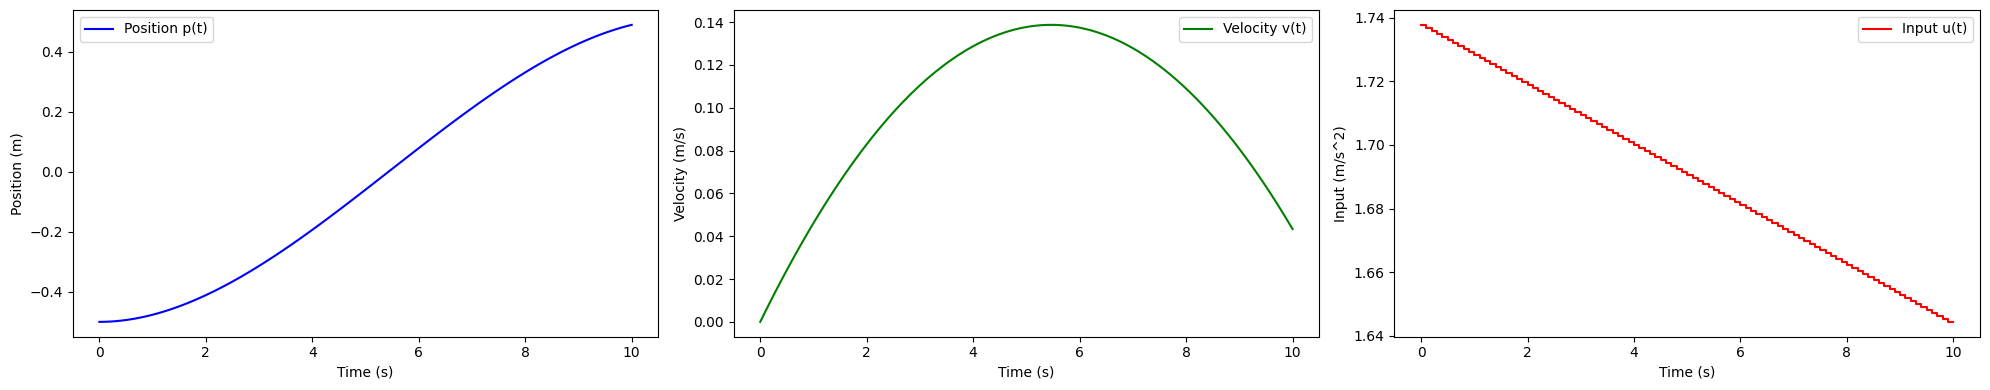

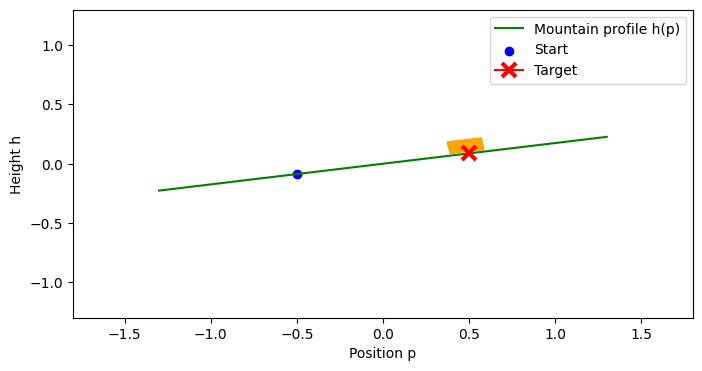

In [11]:
# Instantiate the simulator, and then run the simulation
simulator_dp = Simulator(dynamics, controller_dp, env, 1/freq, t_terminal)
simulator_dp.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_dp = Visualizer(simulator_dp)
visualizer_dp.display_plots()
visualizer_dp.display_animation()



----

#### **Part (d): Implement the Dynamic Programming-based Controller with bang-bang input**


As introduced at the beginning, optimal control problems come in many variations. The control inputs can be either continuous or discrete, and the problems may involve constraints or be unconstrained. In this section, we extend our symbolic DP implementation to handle **discrete-valued control inputs**, also known as **bang-bang control**. Unlike the previous continuous-input case, where the optimal control input was computed by analytically minimizing the cost function using calculus (first-order optimality conditions), here we **explicitly enumerate** all possible control actions (in this case: $ u_k \in \{-1, 1\} $) and choose the one with the **lowest resulting cost**. The differences comparing with the previous continuous input DP are sumerized as follows:

| Feature | Continuous Input DP | Discrete (Bang-bang) DP |
|--------|----------------------|--------------------------|
| Control set | Continuous (e.g., $ u \in \mathbb{R} $) | Discrete ($ u \in \{-0.5, 0.5\} $) |
| Optimal input | Solved symbolically via derivative $ \frac{dJ}{du} = 0 $ | Evaluated explicitly for each candidate input |
| Policy format | Symbolic expression $ \mu_k(x_k) $ | Symbolic piecewise function from enumeration |
| Use case | Smooth unconstrained systems | Input-limited systems (e.g., switched systems) |


**Problem Formulation:**

$$
J_k(\boldsymbol{x_k}) = \min_{u_{k|k}, \ldots, u_{k+N-1|k}} 
\sum_{i=0}^{N-1} u_{k+i|k} ^T \boldsymbol{R} u_{k+i|k}
+ \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)^T \boldsymbol{Q_f} \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)
$$

subject to:

$$
\boldsymbol{x_{k+i+1|k}} = \boldsymbol{A_{d}} \boldsymbol{x_{k+i|k}} + \boldsymbol{B_{d}}u_{k+i|k}, \quad \forall i \in \{0, \ldots, N-1\}
$$

$$
\boxed{u \in \{-0.5, 0.5\}, \quad \forall i \in \{0, \ldots, N-1\}}
$$

$$
\boldsymbol{x_{1,k|k}} = \boldsymbol{x_{1,k}}, \quad \boldsymbol{x_{2,k|k}} = \boldsymbol{x_{2,k}}
$$

**Problem Solving:**

The **main difference** in problem solving lies in the backward recursion step. Instead of analytically minimizing the total cost by solving first-order conditions (as in the continuous case), we now **explicitly evaluate the cost-to-go under each possible input value** from the discrete control set. In this bang-bang setting, the input $ u_k $ is constrained to the values $-0.5$ and $+0.5$.

For each time step $ k $, we proceed as follows:

- First, compute the predicted next state $ \boldsymbol{x}_{k+1} $ for each input candidate (i.e., $ u_k = -0.5 $ and $ u_k = +0.5 $).
- Substitute each predicted state into the next-step cost-to-go function $ J_{k+1} $ to compute the corresponding total cost.
- Compare the two resulting costs symbolically, and use the result to construct a **piecewise control policy**:  
  choose the input that leads to the lower cost.
- Similarly, define the new cost-to-go function $ J_k $ as the minimum of the two evaluated costs, using a piecewise expression.

This approach avoids symbolic differentiation altogether and replaces it with a structured symbolic enumeration strategy, making it well-suited for systems with discrete control constraints.




**Step 1: implement the DP algorithm with bang-bang input**  


The updated `setup_external()` function in the `DPController` class performs similar steps as before to compute a symbolic DP solution with discrete inputs. Most of the structure remains unchanged: symbolic variables are defined for the state and control, cost weights are converted to symbolic form, and the terminal cost is initialized at the final time step.

In [12]:
def setup_external(self) -> None:

    # start timing
    last_time = time.time()

    # Create symbolic states and inputs
    self.x_sym = [sp.Matrix(sp.symbols(f'p_{k} v_{k}')) for k in range(self.N + 1)]
    self.u_sym = [sp.Symbol(f'u_{k}') for k in range(self.N)]

    # Convert numpy weight matrices to sympy matrices
    self.R_sym = sp.Float(self.R)
    self.Qf_sym = sp.Matrix(self.Qf)

    # Convert numpy reference state to sympy array
    self.x_ref_sym = sp.Matrix(self.target_state) 

    # Make a copy
    J, mu = self.J_sym, self.mu_sym

    # Terminal cost: J_N = (x_N - x_ref)^T Qf (x_N - x_ref)
    err_N = self.x_sym[self.N] - self.x_ref_sym
    J[self.N] = (err_N.T * self.Qf_sym * err_N)[0, 0]

    for k in reversed(range(self.N)):
        
        # x_{k+1} = A x_k + B u_k
        x_next = self.Ad * self.x_sym[k] + self.Bd * self.u_sym[k]

        # Cost at step k: u_k^T R u_k + J_{k+1}(x_{k+1})
        stage_cost = self.R_sym * self.u_sym[k]**2
        J_kplus1_sub = J[k + 1].subs({self.x_sym[k + 1][i]: x_next[i] for i in range(2)})

        total_cost = stage_cost + J_kplus1_sub

        # Evaluate cost for u_k = -0.5 and u_k = 0.5
        cost_minus1 = sp.simplify(total_cost.subs(self.u_sym[k], -0.5))
        cost_plus1  = sp.simplify(total_cost.subs(self.u_sym[k], 0.5))

        # Try subtracting to simplify the condition
        delta_cost = sp.simplify(cost_plus1 - cost_minus1)

        # Store optimal control policy as piecewise
        mu_k = sp.Piecewise(
            (-0.5, delta_cost > 0),
            (0.5,  True)  # fallback
        )
        #mu_k = sp.simplify(mu_k)

        # Store cost-to-go as piecewise
        J_k = sp.Piecewise(
            (cost_minus1, delta_cost > 0),
            (cost_plus1,  True)
        )
        #J_k = sp.simplify(J_k)

        # Store the symbolic expressions
        mu[k] = mu_k
        J[k] = J_k
        
        # Timer for each step
        print(f"i = {k}")
        print(f"Time for single step = {time.time() - last_time:.2f} seconds")
        last_time = time.time()
        
    # Log the symbolic expressions back
    self.J_sym = J
    self.mu_sym = mu

    if self.verbose:
        print(f"Dynamic Programming policy with input constraints computed.")
        

**Step 2: bind the defined cost functions and DP algorithm to the class `DPController`**  

- Steps: 

  1) Bind the defined setup function for DP algorithm `setup_external()` to class `DPController`, it will be automatically called by constructor;

  2) Specify the arguments and instantiate the class `DPController`; 

  3) call function `print_solution()` to show the DP policies;

In [13]:
# Bind the defined DP algorithm to the corresponding class, will be automatically called by constructor
DPController.setup = setup_external


# Define the profile of mountain h(p)
case_2 = 1 # 1, 2

# Define the initial / target state
initial_state_2 = np.array([-0.5, 0.0])
target_state_2 = np.array([0.5, 0.0])

# Instantiate class 'Env'
env_2 = Env(case_2, initial_state_2, target_state_2, h, symbolic_theta)

# Instantiate class 'Dynamics'
dynamics_2 = Dynamics(env_2, state_names, input_names, setup_dynamics)



# Define control frequency of controller and time length of simulation
freq_2 = 1
t_terminal_2 = 4 # time length of simulation
horizon_2 = freq_2 * t_terminal_2

# Define weight matrix in stage and terminal cost
Q_2 = np.diag([1, 1])
R_2 = np.array([[0.1]]) # smaller weight because the input need to be larger to balance the effect of gravity
Qf_2 = Q_2

# Instantiate the DP controller class
controller_dp_2 = DPController(env_2, dynamics_2, Q_2, R_2, Qf_2, freq_2, Horizon=horizon_2)

# Show the symbolic expression of the policies
controller_dp_2.print_solution()


u_eq: 00
i = 3
Time for single step = 0.11 seconds
i = 2
Time for single step = 0.87 seconds
i = 1
Time for single step = 12.88 seconds
i = 0
Time for single step = 2301.85 seconds
u_0*(x_0) = Piecewise((-0.5, ITE((1.0*p_0 + 6.0*v_0 > 7.25) & (3.0*p_0 + 14.0*v_0 > 10.75) & ((1.0*p_0 + 6.0*v_0 <= -1.75) | (3.0*p_0 + 14.0*v_0 > 1.75)) & ((1.0*p_0 + 6.0*v_0 <= 3.75) | (3.0*p_0 + 14.0*v_0 > 14.25)) & ((1.0*p_0 + 6.0*v_0 <= 1.75) | (3.0*p_0 + 14.0*v_0 <= -1.75) | (5.0*p_0 + 22.0*v_0 > -0.25) | ((3.0*p_0 + 14.0*v_0 <= 1.75) & (1.0*p_0 + 6.0*v_0 > -1.75))) & ((1.0*p_0 + 6.0*v_0 <= 7.25) | (3.0*p_0 + 14.0*v_0 <= 10.75) | (5.0*p_0 + 22.0*v_0 > 19.25) | ((3.0*p_0 + 14.0*v_0 <= 14.25) & (1.0*p_0 + 6.0*v_0 > 3.75))) & (((1.0*p_0 + 6.0*v_0 > 1.75) & (3.0*p_0 + 14.0*v_0 > -1.75) & ((1.0*p_0 + 6.0*v_0 <= -1.75) | (3.0*p_0 + 14.0*v_0 > 1.75))) | (((1.0*p_0 + 6.0*v_0 <= 1.75) | (3.0*p_0 + 14.0*v_0 <= -1.75) | (6.0*p_0 + 28.0*v_0 > -3.0) | ((3.0*p_0 + 14.0*v_0 <= 1.75) & (1.0*p_0 + 6.0*v_0 > -1.75)) | (

**Step 3: run the simulation to see the performance of controller**  

- Steps: 

  1) Instantiate the class `Simulator` and run function `run_simulation()` to generate the simulated state- and input-trajectory;

  2) Instantiate the class `Visualizer`, run function `display_final_results()` and `display_animation()` to show the simulations;

Simulation finished, will start plotting


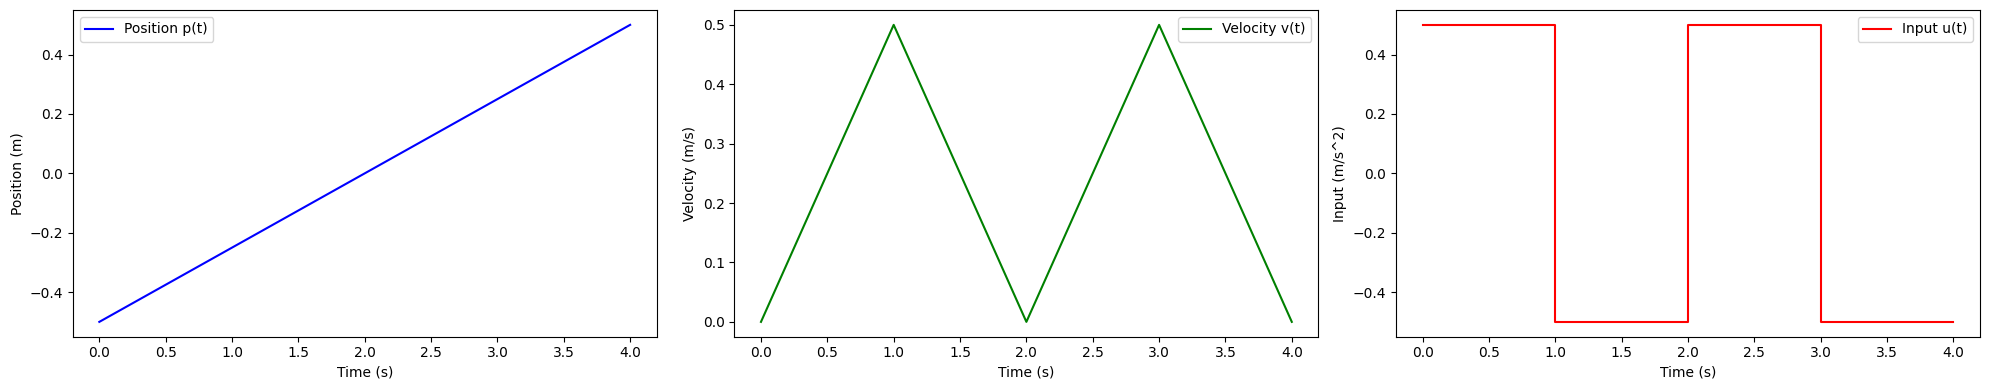

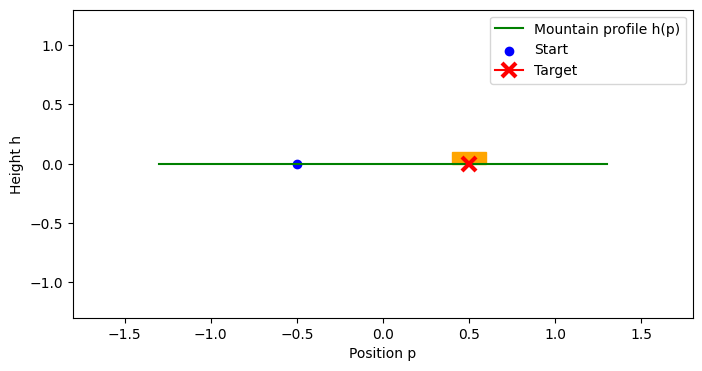

In [14]:
# Instantiate the simulator, and then run the simulation
simulator_dp_2 = Simulator(dynamics_2, controller_dp_2, env_2, 1/freq_2, t_terminal_2)
simulator_dp_2.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_dp_2 = Visualizer(simulator_dp_2)
visualizer_dp_2.display_plots()
visualizer_dp_2.display_animation()

#### **Results Analysis:**

From the simulation results, it can be observed that this control strategy is still capable of driving the Mountain Car system to successfully complete the task. However, from the intermediate printed outputs during the backward recursion, it becomes evident that the computation time per step grows exponentially. When the recursion depth reaches $k=4$, the time required for solving the last step already reaches approximately $40$ minutes.

Moreover, from the final plot of the derived policy expressions, it is clear that the complexity of the expressions increases significantly as the recursion proceeds. This phenomenon occurs because the number of possible system evolutions grows exponentially with the number of steps. For instance, if the control input $u$ is selected from a discrete set such that $u_k \in \{-0.5, 0.5\}$, and the total time horizon is discretized into $N$ steps, then the optimal policy computed at the final iteration would involve evaluating up to $2^N$ different cases.

As a result, this approach inevitably encounters the curse of dimensionality, severely limiting its scalability and practical applicability to problems with longer horizons or larger state and input spaces.